#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом:
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [ ]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 36.8 MB/s 
     |████████████████████████████████| 125 kB 78.0 MB/s 
     |████████████████████████████████| 512 kB 73.5 MB/s 


Скачаем данные

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 18 18:18 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [ ]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [ ]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
import random
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/).

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.image_paths = []
        self.box_paths = []

        for annotation in glob.glob(data_dir + "/*xml"):
            self.box_paths.append(annotation)
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.image_paths.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.fromarray(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])


        converted_boxes = []
        for box in boxes:
          box = self.__convert_to_yolo_box_params(
                                        box,
                                        image.shape[1],
                                        image.shape[0])
          converted_boxes.append(box)


        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=converted_boxes,
                class_labels=class_labels
            )
            image = transformed['image']
            boxes = transformed['bboxes']
            class_labels = transformed['class_labels']


        def class_lablel_to_idx(class_label):
          if class_label == 1:
            return 10
          elif class_label == 2:
            return 11
          elif class_label == 3:
            return 12

        grids = []
        j = 64
        for i in range(7):
          grids.append(j/448)
          j += 64
        max_coords = [] # максимальные значения координат для попадения в grid. всего 49 grids, получаем доступ по индексам
        for g in grids:
          for gr in grids:
              max_coords.append((gr, g))

        target_tensor = [[0]*13]*49

        for i in range(len(boxes)):
          box = boxes[i]
          label = class_labels[i]
          confidence = 1
          xcent = box[0]
          ycent = box[1]
          for j in range(len(max_coords)):
            if xcent < max_coords[j][0] and ycent < max_coords[j][1]:
              grid_idx = j
              break

          target_tensor[grid_idx] = list(box) + [1] + list(box) + [1]+ [0]*3
          target_tensor[grid_idx][class_lablel_to_idx(label)] = 1


        image = torch.Tensor(image)

        image = image.reshape(3, 448, 448)
        target_tensor = torch.Tensor(target_tensor)
        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []


        with open(xml_filename) as f:
                annotation_dict = xmltodict.parse(f.read())
        objects = annotation_dict["annotation"]["object"]

        if not isinstance(objects, list):
            objects = [objects]
        for obj in objects:
            bndbox = obj["bndbox"]
            bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
            bbox = list(map(int, bbox))
            boxes.append(torch.tensor(bbox))
            class_labels.append(class2tag[obj["name"]])
        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].

      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []

      ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
      ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center

      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [ ]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
    A.augmentations.geometric.resize.Resize(width=WIDTH, height=HEIGHT),
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.2)
    ], bbox_params=A.BboxParams(format='yolo',
                                label_fields=['class_labels']))
test_transform = A.Compose(
    [A.augmentations.geometric.resize.Resize(width=WIDTH, height=HEIGHT)],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [ ]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform,
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False)


Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [ ]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]

    :return: Intersection Over Union
    """
    predicted_bbox = predicted_bbox
    gt_bbox = gt_bbox

    intersection_bbox = torch.Tensor(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете.

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье:

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробок и один класс

In [ ]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):

        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        if len(x.shape) == 3:
          x = torch.unsqueeze(x, 0)

        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x

class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3, in_channels=3, **kwargs):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C
        self.in_channels = in_channels

        self.darknet = self._create_conv_layers()
        self.fcs = self._create_fcs(self.S, self.B, self.C)

    def forward(self, x):
        x = self.darknet(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

    def _create_conv_layers(self):
        layers = []
        in_channels = self.in_channels

        layers += [CNNBlock(in_channels, 64, kernel_size=7, stride=2, padding=3, is_max_pool=True)]
        layers += [CNNBlock(64, 192, kernel_size=3, stride=1, padding=1, is_max_pool=True)]
        layers += [CNNBlock(192, 128, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(128, 256, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(256, 256, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, is_max_pool=True)]

        layers += [CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(512, 256, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(256, 512, kernel_size=3, stride=1, padding=1, is_max_pool=False)]

        layers += [CNNBlock(512, 512, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=True)]

        layers += [CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0, is_max_pool=False)]
        layers += [CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=False)]

        layers += [CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(1024, 1024, kernel_size=3, stride=2, padding=1, is_max_pool=False)]
        layers += [CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=False)]
        layers += [CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1, is_max_pool=False)]

        return nn.Sequential(*layers)

    def _create_fcs(self, S, B, C):
        S, B, C = self.S, self.B, self.C
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S*S*(B*5 + C))
        )


temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)


assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0]
assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [ ]:
def get_xyminmax(lst): # получает на вход такой список: [x_center, y_center, width, height]
      x_min = (lst[0] - lst[2]/2) * 448
      x_max = (lst[0] + lst[2]/2) * 448
      y_min = (lst[1] - lst[3]/2) * 448
      y_max = (lst[1] + lst[3]/2) * 448
      return [x_min, y_min, x_max, y_max]

In [ ]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super().__init__()

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5


    def forward(self, predictions, target):
        zero_tensor =  torch.Tensor([0, 0, 0]).to('cuda')

      # первое слагаемое
        predictions = predictions.reshape(4, 49, 13)
        batch_loss = 0
        for n in range(target.shape[0]):

          sum1 = 0
          for i in range(self.S**2):
            b1_iou = intersection_over_union(get_xyminmax(predictions[n][i][0:4]), get_xyminmax(target[n][i][0:4]))
            b2_iou = intersection_over_union(get_xyminmax(predictions[n][i][5:9]), get_xyminmax(target[n][i][5:9]))

            # если в таргете предсказан класс (т.е. вероятности классов не 0) и iou первого bbox больше
            if torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou > b2_iou:
              sum1 += (predictions[n][i][0] - target[n][i][0])**2 + (predictions[n][i][1] - target[n][i][1])**2
            elif torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou < b2_iou:
              sum1 += (predictions[n][i][5] - target[n][i][5])**2 + (predictions[n][i][6] - target[n][i][6])**2

          sum1 = sum1*self.lambda_coord

          # второе слагаемое
          sum2 = 0
          for i in range(self.S**2):
            if torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou > b2_iou:
              sum2 += (abs((predictions[n][i][2]))**(1/2) - (target[n][i][2])**(1/2))**2 + (abs((predictions[n][i][3]))*(1/2) - (target[n][i][3])**(1/2))**2
            elif torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou < b2_iou:
              sum2 += (abs((predictions[n][i][7]))**(1/2) - (target[n][i][7])**(1/2))**2 + (abs((predictions[n][i][8]))*(1/2) - (target[n][i][8])**(1/2))**2

          sum2 = sum2*self.lambda_coord

          # третье слагаемое
          sum3 = 0
          for i in range(self.S**2):
            if torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou > b2_iou:
              sum3 += (predictions[n][i][4] - target[n][i][4])**2
            elif torch.equal(target[n][i][10:], zero_tensor) == False and b1_iou < b2_iou:
              sum3 += (predictions[n][i][9] - target[n][i][9])**2

          # четвертое слагаеомое
          sum4 = 0
          for i in range(self.S**2):
            if torch.equal(target[n][i][10:], zero_tensor) == True:
              sum4 += (predictions[n][i][4] - target[n][i][4])**2

          sum4 = sum4*self.lambda_noobj

          # пятое слагаемое
          sum5 = 0
          for i in range(self.S**2):
            s = 0
            if torch.equal(target[n][i][10:], zero_tensor) == False:
              idx = 10
              for c in range(self.C):
                s += (predictions[n][i][idx] - target[n][i][idx])**2
                idx += 1
            sum5 += s

          total_loss = sum1 + sum2 + sum3 + sum4 + sum5
        batch_loss += total_loss

        return batch_loss/target.shape[0]


## Реализуйте дополнительные функции из статьи - 2 балла

In [ ]:
def non_max_suppression(pred_tensor, iou_threshold, threshold):

    # сначала извлечем из тензора все боксы в формате: [x_center, y_center, width, height, confidence, class1, class2, class3], для боксов принадлежащих одному гриду классы дублиурем
    bboxes = []
    result_boxes = []
    pred_tensor = pred_tensor.reshape(49, 13)

    for grid in pred_tensor:
      bboxes.append(torch.cat([grid[:5], grid[10:]], 0))
      bboxes.append(grid[5:])

    # удаляем все боксы с недостаточным confidence и/или с отрицательными значениями в x_center, y_center, width, height
    conf_bboxes = []
    for box in bboxes:
      if box[4] > threshold and box[0]>0 and box[1]>0 and box[2]>0 and box[3]>0:
        conf_bboxes.append(np.array(box.to('cpu').detach()))

    # сортируем по значению confidence, на первом месте будет бокс с самой большой уверенностью
    sorted_bboxes = sorted(conf_bboxes, key=lambda x: x[4], reverse=True)

    while len(sorted_bboxes) > 0:
      sorted_bboxes_mask = [False] # маска для отсортированного листа, будет показывать какие значения удалять
      result_boxes.append(sorted_bboxes[0])
      gt = get_xyminmax(sorted_bboxes[0][:4])
      for i in range(1, len(sorted_bboxes)):
        pred = get_xyminmax(sorted_bboxes[i][:4])
        iou = intersection_over_union(pred, gt)
        if iou > iou_threshold:
          sorted_bboxes_mask.append(False)
        else:
          sorted_bboxes_mask.append(True)
      sorted_bboxes = np.array(sorted_bboxes)[sorted_bboxes_mask]
    result_boxes = torch.Tensor(result_boxes)
    result_boxes = result_boxes.to('cuda')

    return result_boxes

def get_target_boxes(target_tensor):
    target_boxes = []
    for grid in target_tensor:
      # проверяем, что это бокс с объектом (конфиденс не равен 0)
      if grid[4] != 0:
        target_boxes.append(torch.cat([grid[:5], grid[10:]], 0))
    target_boxes = torch.stack(target_boxes)
    target_boxes = target_boxes.to('cuda')
    return target_boxes

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    model = model.to(device)
    all_pred_boxes = [] # список длины, равной количеству картинок, в каждом индексе лежат боксы в формате: [x_center, y_center, width, height, confidence, class1, class2, class3]
    all_true_boxes = []
    model.eval()

    with torch.no_grad():
        for images, tensors in tqdm.tqdm(loader):
            images, tensors = images.to(device), tensors.to(device)
            batch_pred = model.forward(images)
            for pr in batch_pred:
              pr = pr.reshape(49, 13)
              nonmax_pred = non_max_suppression(pr, iou_threshold, threshold)
              all_pred_boxes.append(nonmax_pred)

            for tensor in tensors:
              target_boxes = get_target_boxes(tensor)
              all_true_boxes.append(target_boxes)

    return all_pred_boxes, all_true_boxes

def get_class(x):
    if np.argmax(x) == 5:
      return 1
    elif np.argmax(x) == 6:
      return 2
    elif np.argmax(x) == 7:
      return 3

def right_class_or_not(cl1, cl2):
  if cl1 == cl2:
    return 1
  return 0

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [ ]:
class YOLOLearner(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()

        self.model = YOLO()
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return {"optimizer": self.optimizer, "lr_scheduler": torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)}

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        images = images.to('cuda')
        target = target.to('cuda')
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss


    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        images = images.to('cuda')
        target = target.to('cuda')
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("val_loss", loss, prog_bar=True)



In [ ]:
dev = "gpu" if torch.cuda.is_available() else "cpu"
model = temp_model.to(device)
n_epochs = 20

yolo_learner = YOLOLearner()

trainer = pl.Trainer(accelerator=dev, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 268 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
268 M     Trainable params
0         Non-trainable params
268 M     Total params
1,073.268 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


При обучении лосс падал, значит, модель что-то да выучила)

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

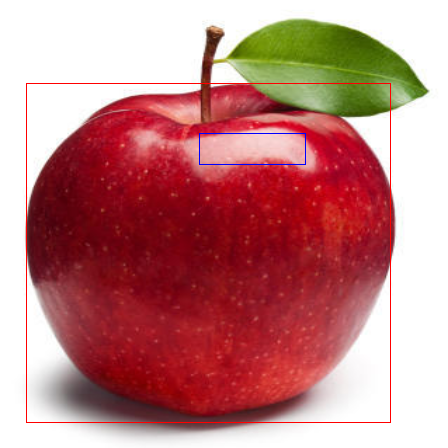

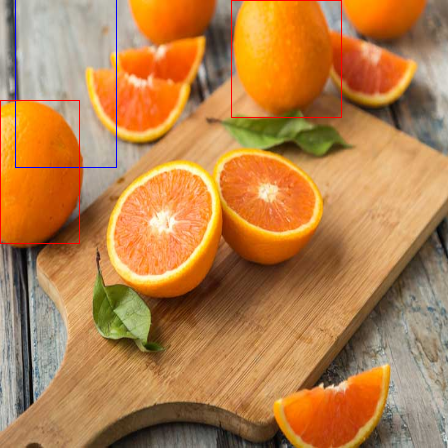

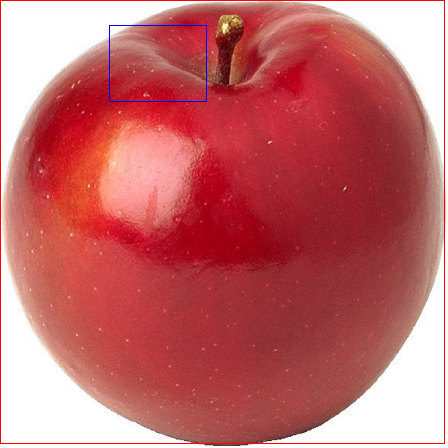

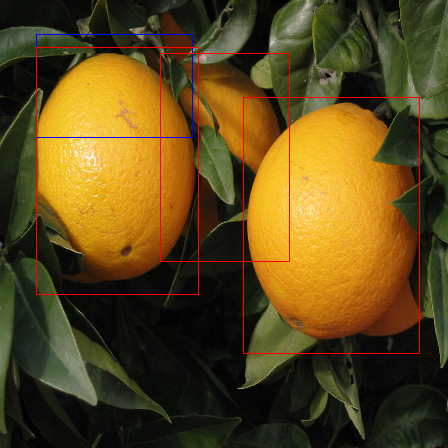

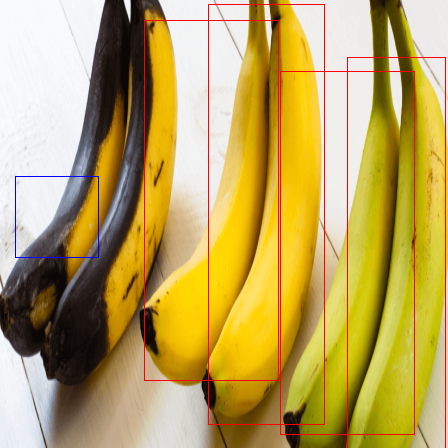

In [ ]:
seed_everything(123456)
from PIL import ImageDraw

j = 0

for images, tensor in val_dataloader:
  for i in range(len(images)):
    image = images[i]
    pred = model(image.to('cuda'))
    image = np.array(image).reshape(448, 448, 3).astype('uint8')

    image = torchvision.transforms.ToPILImage()(image)
    draw = ImageDraw.Draw(image)
    target_boxes = get_target_boxes(tensor[i])


    pred_boxes = non_max_suppression(pred, 0.5, 0.4)

    for box in pred_boxes:
      p_box = get_xyminmax(box[0:4])
      draw.rectangle([(p_box[0], p_box[1]), (p_box[2], p_box[3])], outline='blue')

    for box in target_boxes:
        new_box = get_xyminmax(box[0:4])
        draw.rectangle([(new_box[0], new_box[1]), (new_box[2], new_box[3])], outline='red')
    if (i == 1 and j == 0) or (i == 1 and j == 4) or (i == 2 and j == 1) or (i == 2 and j == 6) or (i == 1 and j == 12):
      display(image)
  j += 1
